In [2]:
##### Load packages #####
library(tidyverse)
library(multcomp)
library(ggplot2)
library(car)
library(MASS)
library(stats)
library(sjPlot)
library(tidyverse)
library(lme4)
library(lmerTest)
library(LMERConvenienceFunctions)
library(multcomp)

In [3]:
# Load CSV
dir_name <- basename(getwd())
csv_file <- paste0(dir_name, ".csv")
graphdata <- read.csv(csv_file)

Trial_list <- c("Trial01", "Trial02", "Trial03", "Trial04", "Trial05", "Trial06", "Trial07", "Trial08", "Trial09", "Trial10")

#add column index
colnames(graphdata) <- paste0(sprintf("%02d", seq_along(colnames(graphdata))), " ", colnames(graphdata))

# Identify rows with NA (used to detect the gaps) in graphdata
gap_rows <- which(rowSums(is.na(graphdata)) == ncol(graphdata))

# Assign groups dynamically using Trial_list
graphdata$Group <- NA  # Initialize Group column

# Create a sequence of rows to handle gaps
gap_rows <- c(0, gap_rows, nrow(graphdata) + 1)  # Include start and end boundaries
current_trial_index <- 1  # Start from the first trial in Trial_list

# Assign groups dynamically
for (i in seq_along(gap_rows[-1])) {
  start <- gap_rows[i] + 1  # Start of the current block
  end <- gap_rows[i + 1] - 1  # End of the current block
  
  if (start <= end) {
    graphdata$Group[start:end] <- Trial_list[current_trial_index]
    current_trial_index <- current_trial_index + 1
    
    # Loop back to the start of Trial_list if necessary
    if (current_trial_index > length(Trial_list)) {
      current_trial_index <- 1
    }
  }
}

# Print the result to check
print(head(graphdata))

# Reshape graphdata to long format and keep Group in the third column
stacked_graphdata <- graphdata %>%
  pivot_longer(cols = -Group,  # Exclude the Group column from pivoting
               names_to = "ind",  # Column names will go to 'ind'
               values_to = "values") %>%  # Data will go to 'values'
  relocate(Group, .after = ind)  # Move Group column to the third position

# View the result
print(head(stacked_graphdata))

# Create the tallcsv dataframe with renamed columns
tallcsv <- stacked_graphdata %>%
  rename(
    VALUE = values,       
    Treatment = ind,      
    Trial = Group         
  ) %>%
  arrange(Trial, Treatment)  

# View the resulting dataframe
print(head(tallcsv))

#delete NA row
tallcsv2 <- tallcsv[!is.na(tallcsv$VALUE),]

#export
csv_file2 <- paste0(dir_name, "_tall.csv")
write.csv(tallcsv2,csv_file2, row.names = FALSE)

   01 wt_0h 02 wt_2h 03 arm23qd_20_0h 04 arm23qd_20_2h 05 arm23qd_32_0h
1 1.0281138 14.65512        0.9885140         15.88948               NA
2 1.0139595 14.45336        0.9614831         15.13692               NA
3 0.9592641 15.81622        1.0521448         16.33619               NA
4        NA       NA               NA               NA               NA
5 1.0643702 15.80165               NA               NA        0.9351912
6 0.9201877 14.94927               NA               NA        0.9416960
  06 arm23qd_32_2h 07 flg22_0h 08 flg22_2h   Group
1               NA   1.0046317    67.80564 Trial01
2               NA   0.9908006    73.17776 Trial01
3               NA   1.0046317    73.68675 Trial01
4               NA          NA          NA    <NA>
5         15.54814   0.9726549    85.54845 Trial02
6         14.20838   0.9794203    89.18133 Trial02
# A tibble: 6 × 3
  ind              Group   values
  <chr>            <chr>    <dbl>
1 01 wt_0h         Trial01  1.03 
2 02 wt_2h         

# A tibble: 6 × 3
  Treatment Trial    VALUE
  <chr>     <chr>    <dbl>
1 01 wt_0h  Trial01  1.03 
2 01 wt_0h  Trial01  1.01 
3 01 wt_0h  Trial01  0.959
4 02 wt_2h  Trial01 14.7  
5 02 wt_2h  Trial01 14.5  
6 02 wt_2h  Trial01 15.8  


[1] 36 35

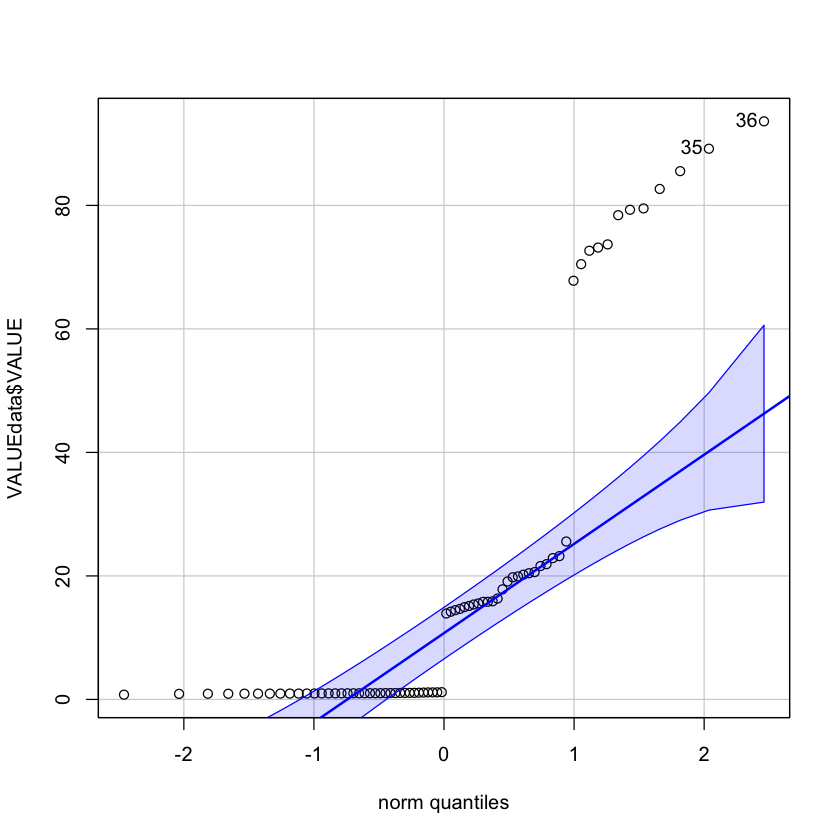

In [4]:
#VALUEdata=read.csv(choose.files())
VALUEdata <- tallcsv2
VALUEdata$VALUE <- as.numeric(as.character(VALUEdata$VALUE))
print(head(VALUEdata))
#Normal distribution
qqp(VALUEdata$VALUE, "norm")

Linear mixed model fit by maximum likelihood . t-tests use Satterthwaite's
  method [lmerModLmerTest]
Formula: VALUE ~ Treatment + (1 | Trial)
   Data: VALUEdata

     AIC      BIC   logLik deviance df.resid 
   406.2    429.0   -193.1    386.2       62 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.7516 -0.2793 -0.0655  0.4548  4.1283 

Random effects:
 Groups   Name        Variance Std.Dev.
 Trial    (Intercept)  1.414   1.189   
 Residual             11.735   3.426   
Number of obs: 72, groups:  Trial, 4

Fixed effects:
                           Estimate Std. Error        df t value Pr(>|t|)    
(Intercept)                1.004721   1.153853 20.085479   0.871    0.394    
Treatment02 wt_2h         17.603673   1.398493 67.150664  12.588  < 2e-16 ***
Treatment03 arm23qd_20_0h  0.785653   1.754478 70.747249   0.448    0.656    
Treatment04 arm23qd_20_2h 17.152057   1.754478 70.747249   9.776 9.11e-15 ***
Treatment05 arm23qd_32_0h -0.790077   1.754478 70.747249  -0.45

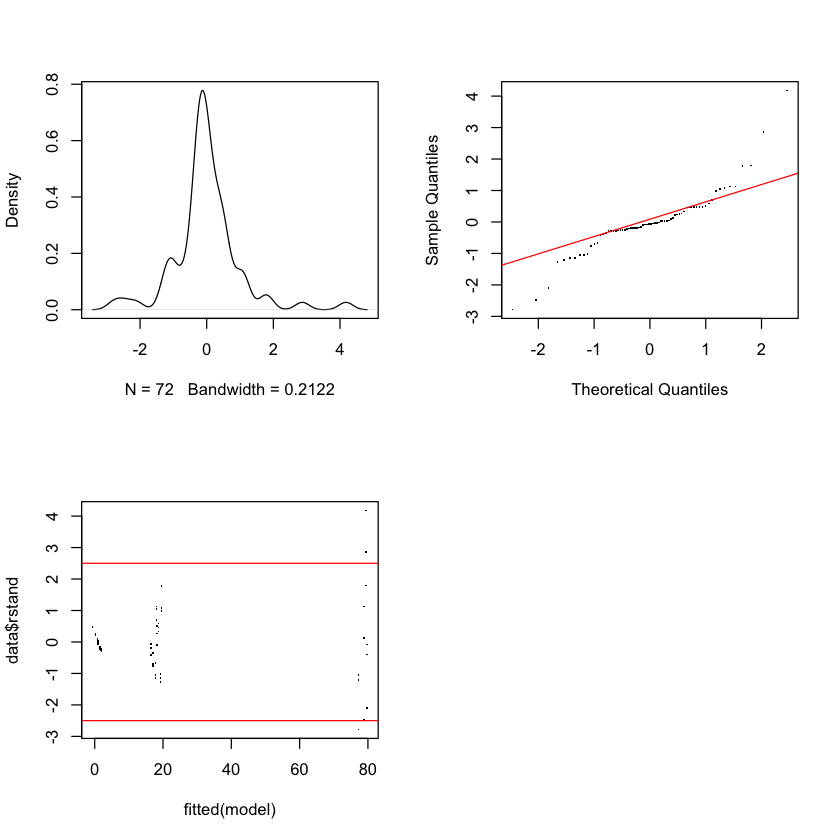

In [5]:
#set REML to FALSE if the data is normal, so we can use the maximum likelihood because the data are normal, we have similar sample sizes between effects, and we only have one random effect
VALUE.lmm<-lmer(VALUE ~ Treatment + (1|Trial), data = VALUEdata, REML = FALSE)
m<-lmer(VALUE ~ Treatment + (1|Trial), data = VALUEdata, REML = FALSE)
#the density plot should look roughly normal, centered on 0. In the quantile plot the black dots should roughly mirror the red line. And in the fitted residual plot most black dots should be between the red lines, with no obvious skew from left to right.
mcp.fnc(VALUE.lmm)
#If the above looks good, then we can get the model characteristics
summary(VALUE.lmm)
summary_name1 <- paste0("01.",dir_name, "_LMM_summary.txt")
capture.output(summary(VALUE.lmm), file = summary_name1)

In [6]:
#anova analysis of lmm
aov <- anova(m)
print(summary(aov))
# Save the summary to a text file
summary_name2 <- paste0("02.",dir_name, "_anova_summary.txt")
capture.output(summary(aov), file = summary_name2)

#Tukey's post-hoc, load library multcomp
tukey_result <- glht(m, linfct = mcp(Treatment = "Tukey"))
multcomps <- cld(tukey_result, alpha=0.1)
print(summary(tukey_result))
# Save the summary to a text file
summary_name3 <- paste0("03.",dir_name, "_multcomp_summary.txt")
capture.output(summary(tukey_result), file = summary_name3)

print(multcomps)
multcomp_name <- paste0("04.",dir_name, "_multcomp_letters.txt")
capture.output(print(multcomps), file = multcomp_name)

     Sum Sq         Mean Sq         NumDF       DenDF          F value   
 Min.   :54625   Min.   :7804   Min.   :7   Min.   :66.48   Min.   :665  
 1st Qu.:54625   1st Qu.:7804   1st Qu.:7   1st Qu.:66.48   1st Qu.:665  
 Median :54625   Median :7804   Median :7   Median :66.48   Median :665  
 Mean   :54625   Mean   :7804   Mean   :7   Mean   :66.48   Mean   :665  
 3rd Qu.:54625   3rd Qu.:7804   3rd Qu.:7   3rd Qu.:66.48   3rd Qu.:665  
 Max.   :54625   Max.   :7804   Max.   :7   Max.   :66.48   Max.   :665  
     Pr(>F)         
 Min.   :6.091e-59  
 1st Qu.:6.091e-59  
 Median :6.091e-59  
 Mean   :6.091e-59  
 3rd Qu.:6.091e-59  
 Max.   :6.091e-59  

	 Simultaneous Tests for General Linear Hypotheses

Multiple Comparisons of Means: Tukey Contrasts


Fit: lmer(formula = VALUE ~ Treatment + (1 | Trial), data = VALUEdata, 
    REML = FALSE)

Linear Hypotheses:
                                           Estimate Std. Error z value Pr(>|z|)
02 wt_2h - 01 wt_0h == 0                  1